In [13]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Input, Model, regularizers
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from scipy.stats import norm

In [14]:
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [15]:
# network parameters
original_dim = 5000 * 1
input_shape = (original_dim, )
intermediate_dim_0 = 1536
intermediate_dim_1 = 1024
intermediate_dim_2 = 512
batch_size = 128
latent_dim = 2
epochs = 70

REGULAR = "reg"
CHIMERIC = "chi"
REPEAT = "rep"
LOW_QUALITY = "loq"

INPUT_LENGTH = 5000
INPUT_THRESHOLD = 1000

NUM_CLASSES = 3


def create_datasets(tsv_input):
    data = pd.read_csv(tsv_input, delimiter="\t")

    # Filter out all low quality reads
    data = data.loc[data.CAT != LOW_QUALITY]

    # Convert sequence string to float array
    data.PTS = data.PTS.apply(string_to_array)

    # Convert labels from strings to ints
    ys = data.CAT.apply(category_to_int).to_numpy()
    xs = np.stack(data.PTS.array)

    encoded_ys = to_categorical(ys, num_classes=NUM_CLASSES)

    print("XS shape: {}".format(xs.shape))
    print("One-hot encoded YS shape: {}".format(encoded_ys.shape))

    train_x, test_x, train_y, test_y = train_test_split(xs, encoded_ys, test_size=0.15)

    return train_x, train_y, test_x, test_y

def string_to_array(data):
    data_string = str(data)
    split = data_string.split(',')

    return np.array([float(i) for i in split])


def category_to_int(data):
    category = str(data)
    if category == REGULAR:
        return 0
    elif category == REPEAT:
        return 1
    else:
        return 2
    
def plot_loss(model):
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    plt.figure()
    plt.plot(loss, 'r-', label='Training loss')
    plt.plot(val_loss, 'b-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    
def plot_decoded(decoded_x, n):
    idxs = range(INPUT_LENGTH)

    fig, ax = plt.subplots(nrows=n, ncols=n, figsize=(15,10))
    fig.patch.set_visible(False)

    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            col.axis('off')
            col.plot(idxs, decoded_x[i * n + j].tolist())
    plt.savefig('grid_generated_vae_svm.png', facecolor='w')
    print("*****   Manifold generation complete   *****")


def plot_confusion_matrix(matrix):
    df_cm = pd.DataFrame(matrix, ["regular", "repeat", "chimeric"], ["regular", "repeat", "chimeric"])
    plt.figure(figsize=(10, 7))
    sb.heatmap(df_cm, annot=True)
    plt.show()

In [16]:
# build encoder
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim_0, activation='relu')(inputs)
x = Dense(intermediate_dim_1, activation='relu')(x)
x = Dense(intermediate_dim_2, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [17]:
# Use reparameterization trick to push the sampling out as input
z = Lambda(sampling, name='z')([z_mean, z_log_var])

In [18]:
# instantiate encoder
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

plot_model(encoder, to_file='vae_mlp_svm_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 5000)         0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 1536)         7681536     encoder_input[0][0]              
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 1024)         1573888     dense_7[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 512)          524800      dense_8[0][0]                    
__________________________________________________________________________________________________
z_mean (De

In [19]:
# build decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim_2, activation='relu')(latent_inputs)
x = Dense(intermediate_dim_1, activation='relu')(x)
x = Dense(intermediate_dim_0, activation='relu')(x)

outputs = Dense(original_dim, activation='sigmoid')(x)

In [20]:
# instantiate decoder
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

plot_model(decoder, to_file='vae_mlp_svm_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               1536      
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_12 (Dense)             (None, 1536)              1574400   
_________________________________________________________________
dense_13 (Dense)             (None, 5000)              7685000   
Total params: 9,786,248
Trainable params: 9,786,248
Non-trainable params: 0
_________________________________________________________________


In [21]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp_svm')

In [22]:
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

In [23]:
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

plot_model(vae, to_file='vae_mlp_svm.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 5000)              0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 9782276   
_________________________________________________________________
decoder (Model)              (None, 5000)              9786248   
Total params: 19,568,524
Trainable params: 19,568,524
Non-trainable params: 0
_________________________________________________________________


XS shape: (330, 5000)
One-hot encoded YS shape: (330, 3)
Train on 280 samples, validate on 50 samples
Epoch 1/70
280/280 [==============================] - 4s 14ms/step - loss: 402.3725 - val_loss: 1042.8414
Epoch 2/70
280/280 [==============================] - 2s 8ms/step - loss: 372.6047 - val_loss: 240.1539
Epoch 3/70
280/280 [==============================] - 2s 8ms/step - loss: 205.7149 - val_loss: 216.3855
Epoch 4/70
280/280 [==============================] - 1s 5ms/step - loss: 196.0142 - val_loss: 252.1436
Epoch 5/70
280/280 [==============================] - 2s 8ms/step - loss: 208.7953 - val_loss: 203.4253
Epoch 6/70
280/280 [==============================] - 1s 5ms/step - loss: 178.6561 - val_loss: 211.2074
Epoch 7/70
280/280 [==============================] - 2s 8ms/step - loss: 188.6103 - val_loss: 160.3960
Epoch 8/70
280/280 [==============================] - 2s 8ms/step - loss: 137.7374 - val_loss: 141.7849
Epoch 9/70
280/280 [==============================] - 3s 9ms/ste

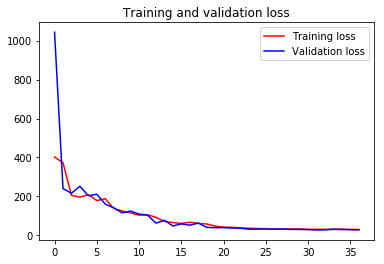

In [24]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
cp = ModelCheckpoint(filepath="vae_mlp_svm.h5", save_best_only=True, verbose=0)

train_x, train_y, test_x, test_y = create_datasets("/floyd/input/overlaps/categorized_400.tsv")
train_x = train_x / np.max(train_x)
test_x = test_x / np.max(test_x)

history = vae.fit(train_x, epochs=epochs, batch_size=batch_size, validation_data=(test_x, None), callbacks=[es, cp])
plot_loss(history)

In [25]:
# Train SVM classifier on training labels \& training latent samples
train_z, _, _ = encoder.predict(train_x, batch_size=batch_size)
print("Training Z shape: {}".format(train_z.shape))

svm = SVC(kernel='rbf')
svm.fit(train_z, train_y.argmax(axis=1))

Training Z shape: (280, 2)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

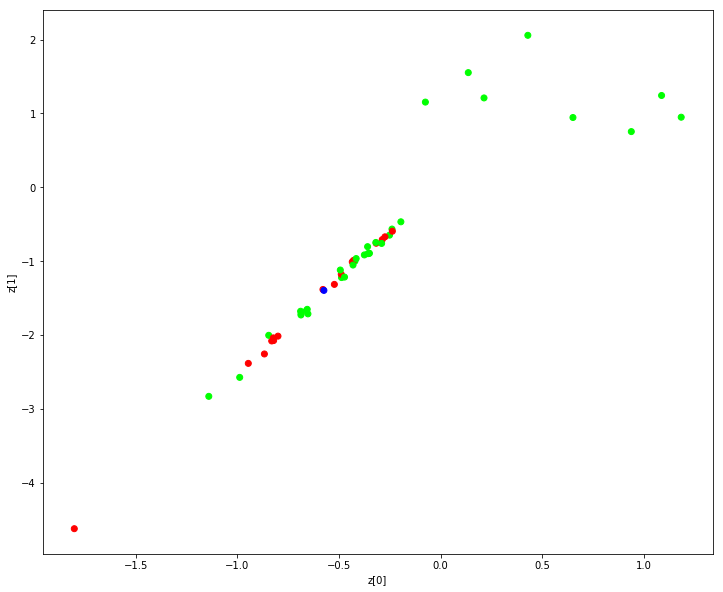

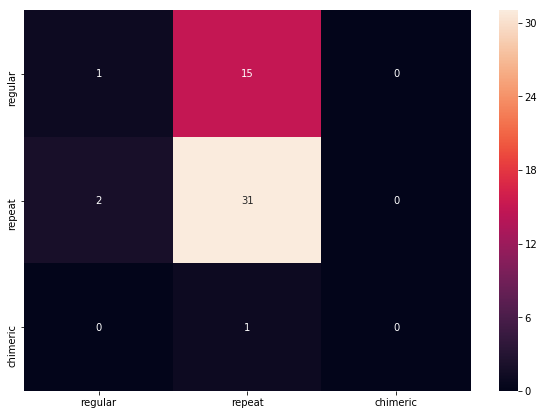

             precision    recall  f1-score   support

          0       0.33      0.06      0.11        16
          1       0.66      0.94      0.78        33
          2       0.00      0.00      0.00         1

avg / total       0.54      0.64      0.55        50



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [26]:
# Test classifier
test_z, _, _ = encoder.predict(test_x, batch_size=batch_size)

plt.figure(figsize=(12, 10))
plt.scatter(test_z[:, 0], test_z[:, 1], c=test_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()


pred_y = svm.predict(test_z)

matrix = metrics.confusion_matrix(test_y.argmax(axis=1), pred_y)
plot_confusion_matrix(matrix)

print(metrics.classification_report(test_y.argmax(axis=1), pred_y))